In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns

In [2]:
magic_num = 1

if magic_num == 0:
    source_path = r"C:/Cody/Research/clean_data/prepare.csv"
    output_graph_file = r"C:/Cody/Research/Chapter4資料探勘與趨勢分析/TicketSituationDifference_chart/"
elif magic_num == 1:
    source_path = r"D:/Research/clean_data/prepare.csv"
    output_graph_file = r"D:/Research/Chapter4資料探勘與趨勢分析/TicketSituationDifference_chart/"
else:
    print("wrong magic num.")
    exit(1)

data = pd.read_csv(source_path)

In [3]:
data["全時間格式進入時間"] = pd.to_datetime(data["全時間格式進入時間"], errors="coerce")
data["全時間格式出場時間"] = pd.to_datetime(data["全時間格式出場時間"], errors="coerce")
# 移除時間缺失與異常值
data = data.dropna(subset=["全時間格式進入時間", "全時間格式出場時間"])
data = data[data["全時間格式出場時間"] > data["全時間格式進入時間"]]

# 不須分析機車
data = data[data["票種"] != "學生機車證"]

In [4]:
tag = data["票種"].unique()
print("票種清單:", tag)
ticket_directory = {}

for each_cat in tag:
    temp_df = data[data["票種"] == each_cat].copy()  # 創建獨立副本
    if temp_df.empty:
        print(f"警告: {each_cat} 無數據，已跳過")
        continue
    temp_df.loc[:, "停留時數_分鐘"] = (temp_df["全時間格式出場時間"] - temp_df["全時間格式進入時間"]).dt.total_seconds() / 60  # 使用 .loc 賦值
    ticket_directory[each_cat] = temp_df
    print(f"{each_cat}: {len(temp_df)} 筆記錄")

票種清單: ['臨停車' '學生計次汽車' '教職員汽車' '學生長時汽車' '臨時貴賓' '廠商汽車證' '教職員計次' '身障優惠'
 '退休及校友汽車識別證' '在職專班汽車' '退休及校友臨停' '互惠車輛' '長時廠商汽車' '特殊入校車輛']
臨停車: 503024 筆記錄
學生計次汽車: 75773 筆記錄
教職員汽車: 288993 筆記錄
學生長時汽車: 53146 筆記錄
臨時貴賓: 31594 筆記錄
廠商汽車證: 75293 筆記錄
教職員計次: 5711 筆記錄
身障優惠: 2285 筆記錄
退休及校友汽車識別證: 27704 筆記錄
在職專班汽車: 18273 筆記錄
退休及校友臨停: 8615 筆記錄
互惠車輛: 4329 筆記錄
長時廠商汽車: 2530 筆記錄
特殊入校車輛: 42 筆記錄


In [5]:
for cat in ticket_directory:
    print(f"{cat}  停留時數_分鐘範圍: {ticket_directory[cat]['停留時數_分鐘'].min():.2f} - {ticket_directory[cat]['停留時數_分鐘'].max():.2f}")

臨停車  停留時數_分鐘範圍: 0.02 - 10078.20
學生計次汽車  停留時數_分鐘範圍: 0.12 - 10074.25
教職員汽車  停留時數_分鐘範圍: 0.02 - 10079.10
學生長時汽車  停留時數_分鐘範圍: 0.15 - 10066.58
臨時貴賓  停留時數_分鐘範圍: 0.10 - 10022.88
廠商汽車證  停留時數_分鐘範圍: 0.05 - 10074.47
教職員計次  停留時數_分鐘範圍: 0.35 - 7754.07
身障優惠  停留時數_分鐘範圍: 1.13 - 2390.27
退休及校友汽車識別證  停留時數_分鐘範圍: 0.23 - 9814.00
在職專班汽車  停留時數_分鐘範圍: 0.10 - 8920.25
退休及校友臨停  停留時數_分鐘範圍: 1.63 - 1862.87
互惠車輛  停留時數_分鐘範圍: 0.27 - 6615.18
長時廠商汽車  停留時數_分鐘範圍: 0.30 - 8998.30
特殊入校車輛  停留時數_分鐘範圍: 0.50 - 7166.38


# 開始對各式票種分析停留時間分布

In [ ]:
# 設定中文字型
plt.rcParams['font.family'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False  # 確保負號顯示正確

# 確保資料夾存在
output_dir = "Ticket_stay_time"
os.makedirs(output_dir, exist_ok=True)

# 定義直方圖的 bin（15 分鐘 = 0.25 小時）
bin_width = 0.25
short_start, short_end = 0.5, 1
regular_start, regular_end = 6, 8
# 換算為 index
short_start_idx = int(short_start / bin_width)
short_end_idx = int(short_end / bin_width)
regular_start_idx = int(regular_start / bin_width)
regular_end_idx = int(regular_end / bin_width)

max_hours = 16  # 統計到 16 小時
bins = np.arange(0, max_hours + bin_width, bin_width)
print("Bins 數量:", len(bins) - 1)



for cat in ticket_directory:
    # 計算該票種總資料數
    total_count = len(ticket_directory[cat])
    # 計算落在 16 小時內的資料數（即 bins 範圍內）
    stay_hours = ticket_directory[cat]['停留時數_分鐘'] / 60
    in_range_mask = (stay_hours >= 0) & (stay_hours < max_hours)
    in_range_count = in_range_mask.sum()
    

    # 計算百分比
    in_range_percent = (in_range_count / total_count )* 100 if total_count > 0 else 0

    # 計算每筆資料對應的區間
    ticket_directory[cat]['停留時數_分鐘'] = ticket_directory[cat]['停留時數_分鐘'].astype(float)
    hist, edges = pd.cut(stay_hours, bins=bins, right=False, include_lowest=True, retbins=True)


    # 計算每個區間的數量
    counts = hist.value_counts(sort=False)

    # 畫圖
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar', width=0.8, color='skyblue', edgecolor='black')
    plt.title(f'{cat} 停留時間統計', fontsize=16)
    plt.xlabel('停留時間區間 (小時)', fontsize=12)
    plt.ylabel('數量', fontsize=12)

    # 設置 x 軸刻度（每 0.25 小時一格，但只標整數小時）
    tick_positions = np.arange(0, max_hours + bin_width, bin_width)  # 每 15 分鐘一格
    tick_labels = [str(int(x)) if x.is_integer() else "" for x in tick_positions]  # 只標整數小時

    # 對應 bar chart 的每個 bin，用 index 設定 xticks（從 0 開始）
    plt.xticks(np.arange(len(tick_positions)), tick_labels, rotation=0)

    # 設定 x 軸刻度與標籤
    plt.xticks(np.arange(len(tick_positions)), tick_labels)

    plt.text(0.95, 0.90, f"0-16 小時數據占比：{in_range_percent:.2f}%", 
                 transform=plt.gca().transAxes, fontsize=12, 
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.tight_layout()
    # 匯出圖檔
    save_path = os.path.join(output_dir, f"{cat}_停留時間統計.png")
    plt.savefig(save_path, dpi=300)
    plt.close()


Bins 數量: 64


## 聚焦後段趨勢

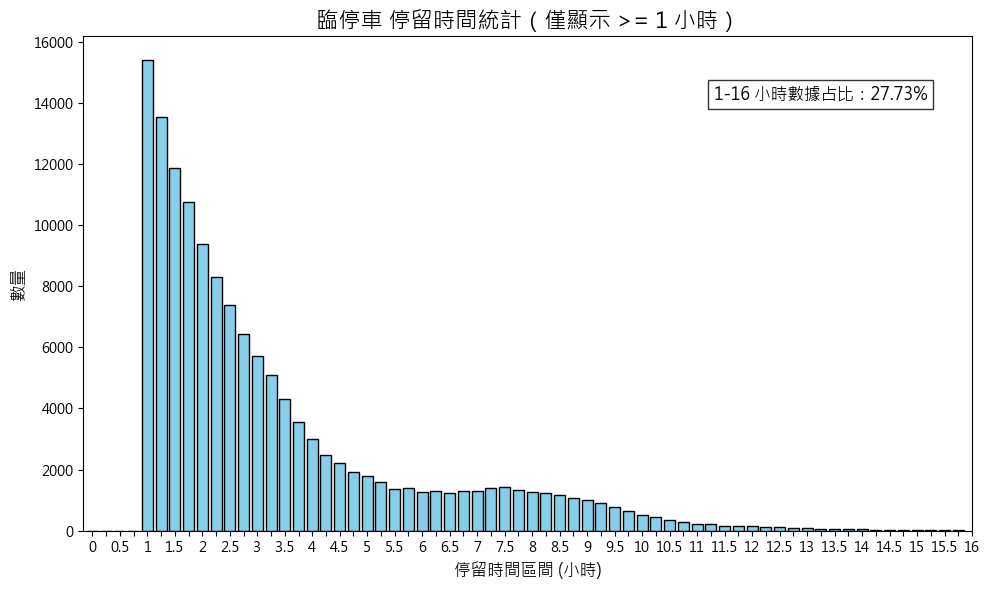

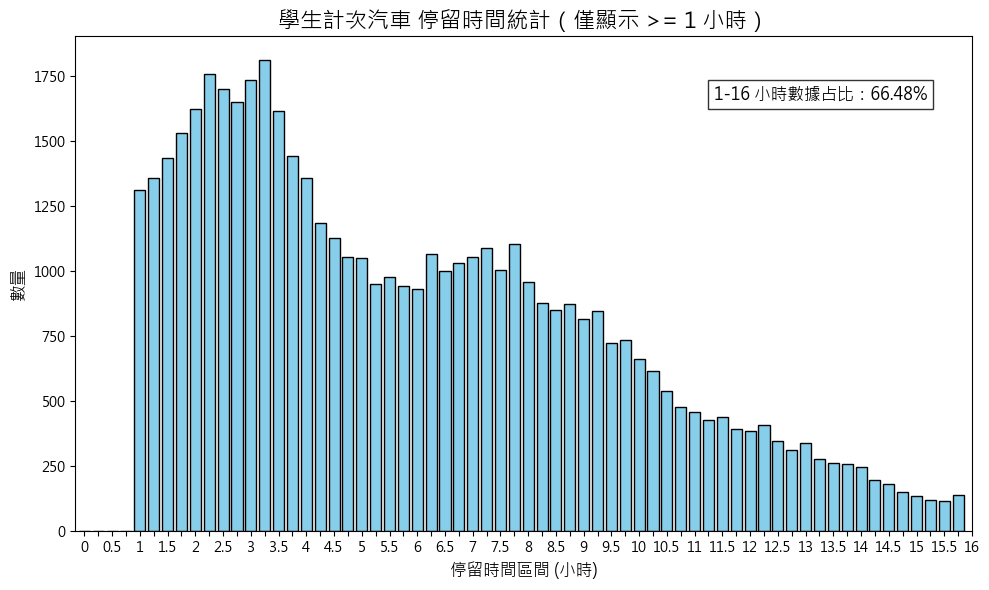

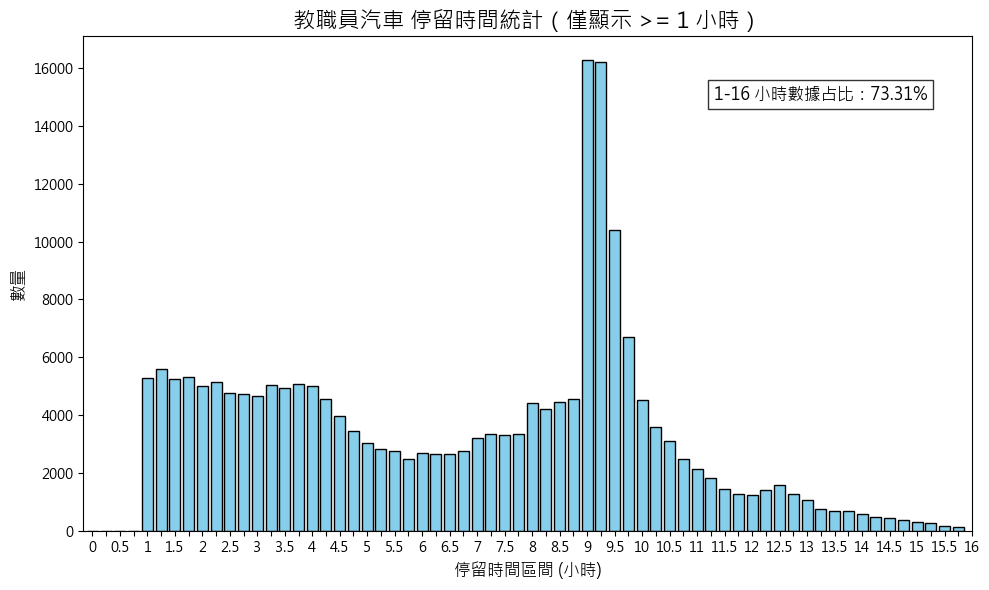

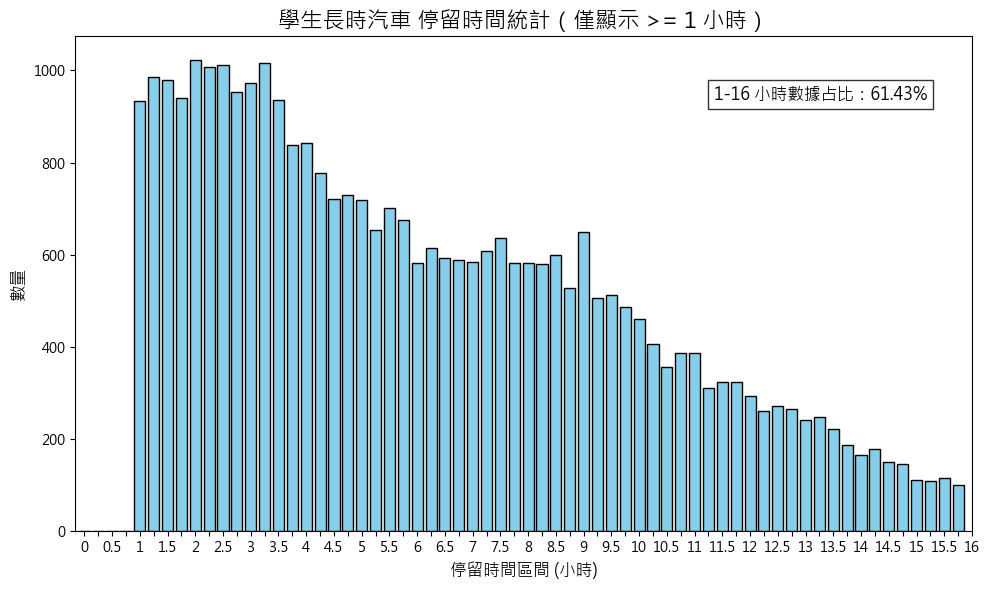

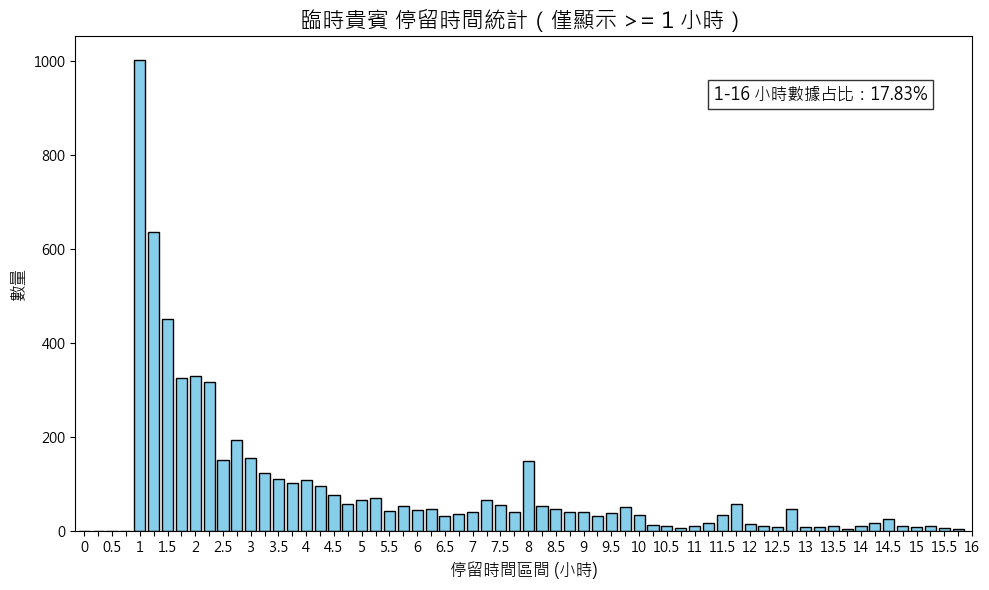

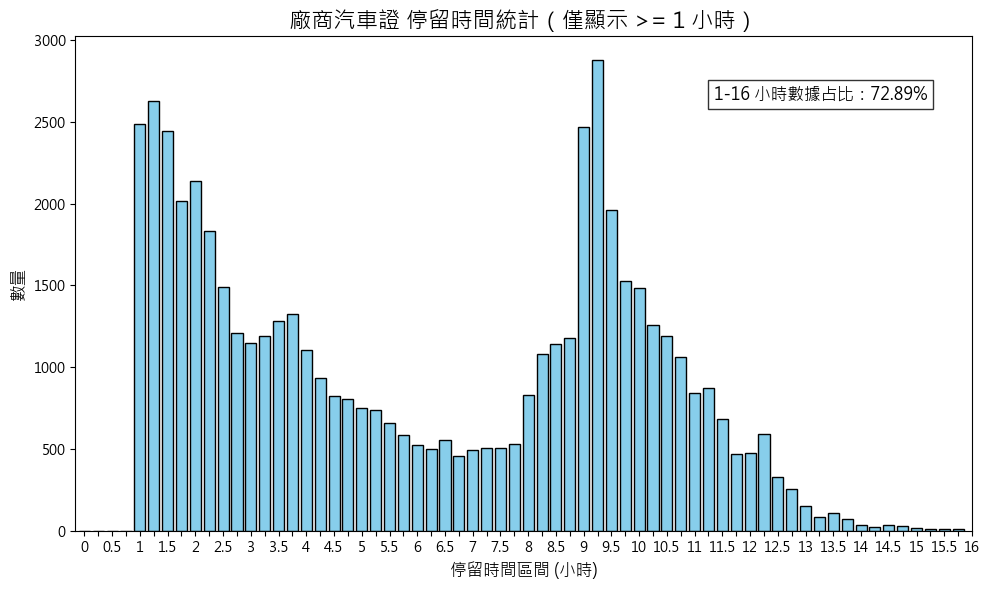

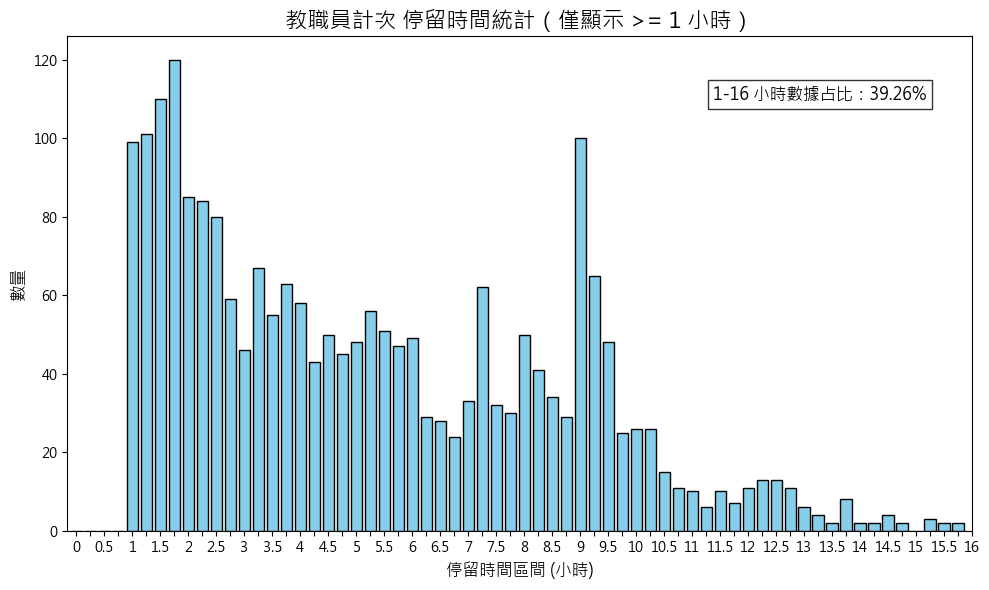

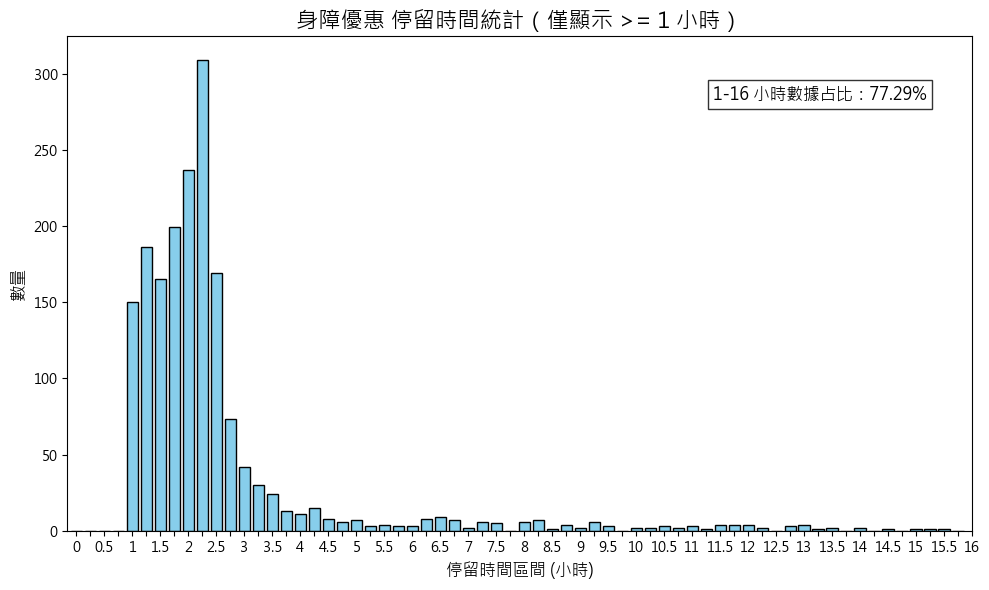

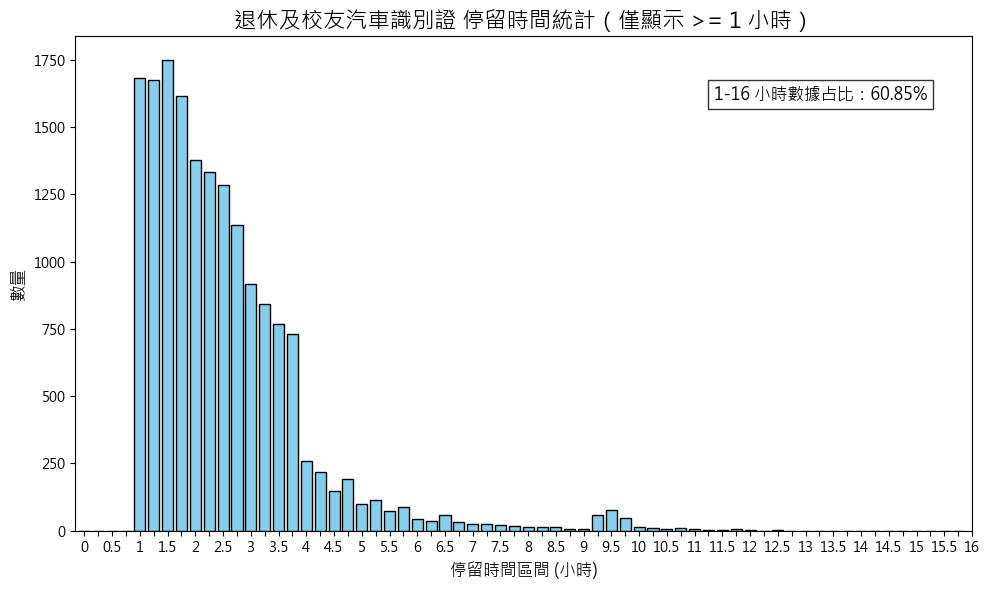

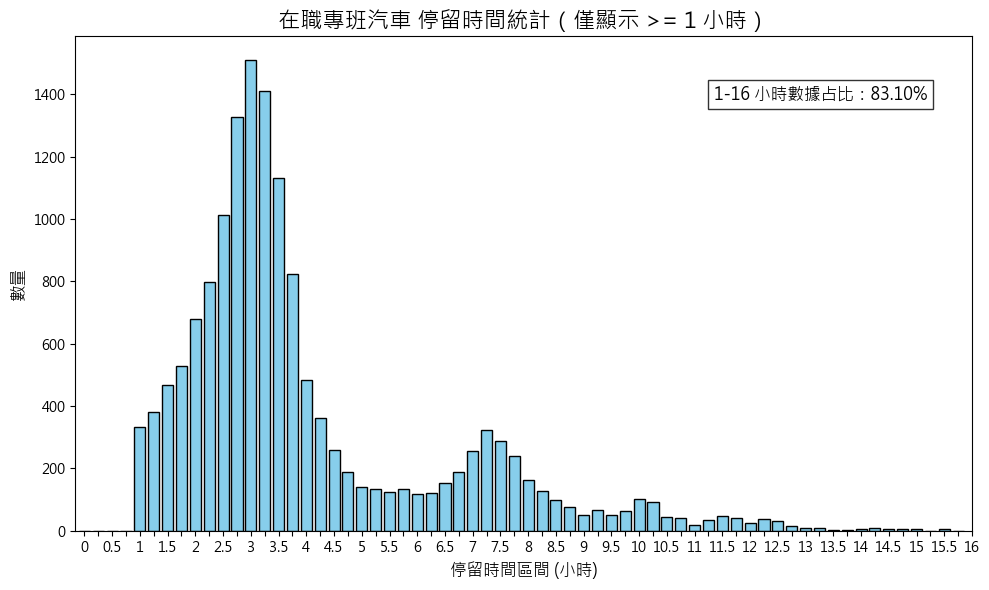

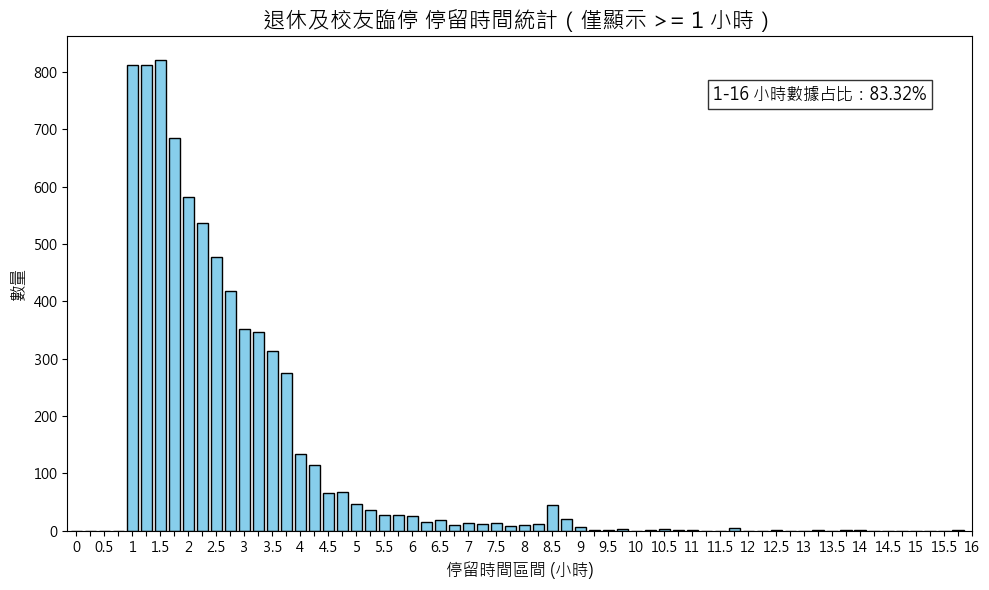

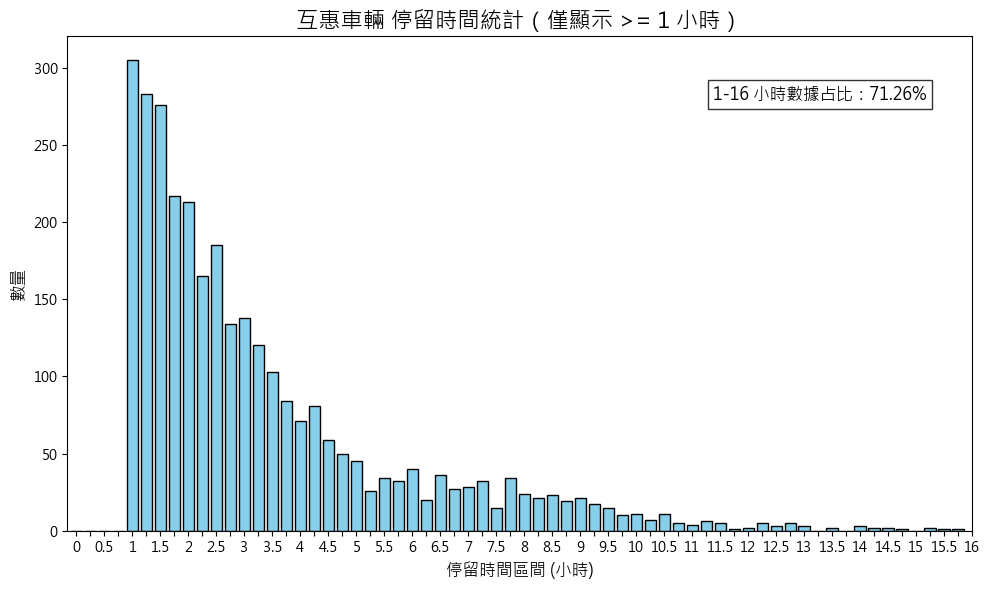

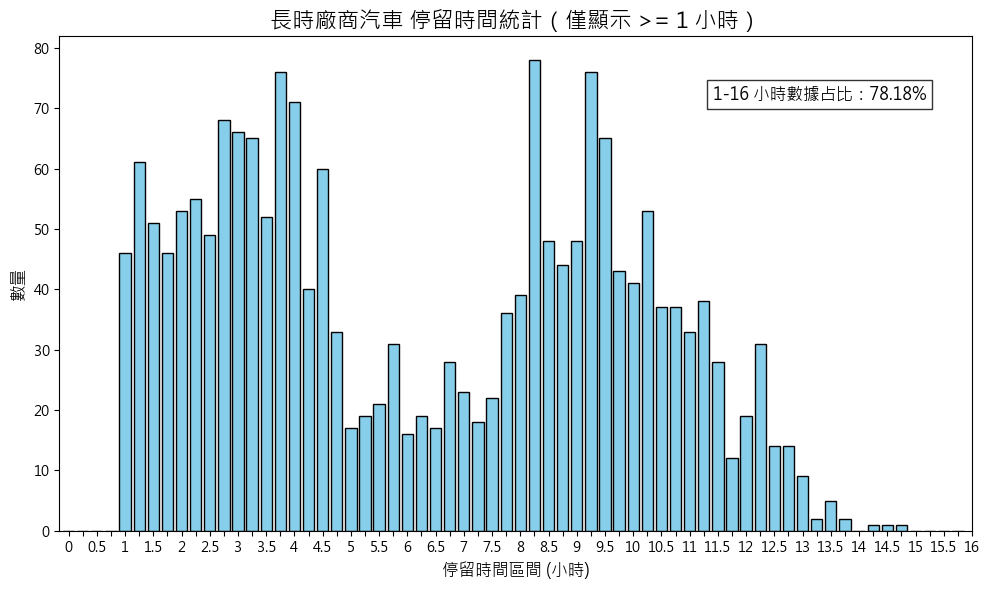

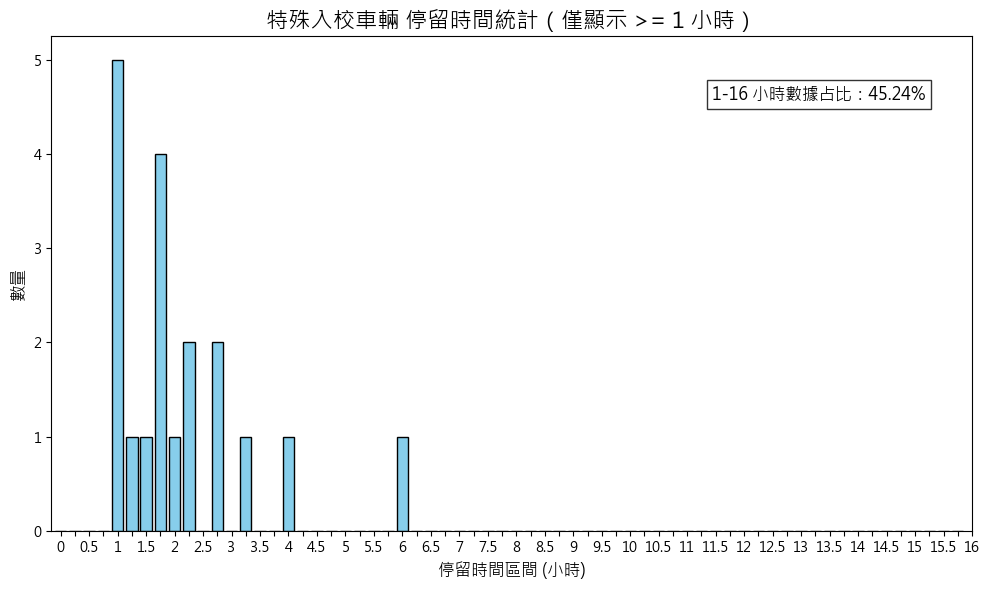

In [ ]:
plt.rcParams['font.family'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False  # 確保負號顯示正確
# 每次迴圈一個票種
for cat in ticket_directory:
    # 原始資料換算為小時
    stay_hours = ticket_directory[cat]['停留時數_分鐘'] / 60
    stay_hours = stay_hours[stay_hours >= 1]  # ✅ 只保留 ≥ 1 小時

    total_count = len(ticket_directory[cat])  # 全部資料（用來算百分比）
    in_range_mask = (stay_hours >= 1) & (stay_hours < max_hours)
    in_range_count = in_range_mask.sum()
    in_range_percent = (in_range_count / total_count) * 100 if total_count > 0 else 0

    # 計算每筆資料對應的區間（cut 會自動忽略不在 bins 的值）
    hist, edges = pd.cut(stay_hours, bins=bins, right=False, include_lowest=True, retbins=True)
    counts = hist.value_counts(sort=False)

    # 畫圖
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar', width=0.8, color='skyblue', edgecolor='black')
    plt.title(f'{cat} 停留時間統計（僅顯示 >= 1 小時）', fontsize=16)
    plt.xlabel('停留時間區間 (小時)', fontsize=12)
    plt.ylabel('數量', fontsize=12)

    # 設定 x 軸：每 0.25 小時一格，整數與 0.5 顯示數字
    tick_positions = np.arange(0, max_hours + bin_width, bin_width)
    tick_labels = [str(int(x)) if x % 1 == 0 else str(x) if x % 1 == 0.5 else "" for x in tick_positions]
    plt.xticks(np.arange(len(tick_positions)), tick_labels, rotation=0)

    plt.text(0.95, 0.90, f"1-16 小時數據占比：{in_range_percent:.2f}%", 
             transform=plt.gca().transAxes, fontsize=12, 
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.tight_layout()
    save_path = os.path.join(output_dir, f"{cat}_停留時間統計(僅顯示1小時以上).png")
    plt.savefig(save_path, dpi=300)
    plt.close()
